In [1]:
%cd Experiment-Simulation/

/home/jofrony/Documents/Repositories/BasalGangliaExperiments/Neuromodulation-software/local/adaptive/Experiment-Simulation


In [2]:
import neuron
neuron.h.load_file('stdrun.hoc')
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!nrnivmodl mechanisms-modulation-ptr/

/home/jofrony/Documents/Repositories/BasalGangliaExperiments/Neuromodulation-software/local/adaptive/Experiment-Simulation
ls: cannot access 'mechanisms-modulation-ptr//*.inc': No such file or directory
mechanisms-modulation-ptr//bk_ch.mod mechanisms-modulation-ptr//bk_fs.mod mechanisms-modulation-ptr//bk_ms.mod mechanisms-modulation-ptr//ca_ch.mod mechanisms-modulation-ptr//cadyn_fs.mod mechanisms-modulation-ptr//cadyn_ms.mod mechanisms-modulation-ptr//cal12_ms.mod mechanisms-modulation-ptr//cal12_ms_ptr.mod mechanisms-modulation-ptr//cal13_ms.mod mechanisms-modulation-ptr//cal13_ms_ptr.mod mechanisms-modulation-ptr//cal_ch.mod mechanisms-modulation-ptr//cal_ch_ptr.mod mechanisms-modulation-ptr//caldyn_ms.mod mechanisms-modulation-ptr//can_fs.mod mechanisms-modulation-ptr//can_ms.mod mechanisms-modulation-ptr//can_ms_ptr.mod mechanisms-modulation-ptr//cap_ch.mod mechanisms-modulation-ptr//cap_ch_ptr.mod mechanisms-modulation-ptr//caq_fs.mod mechanisms-modulation-ptr//caq_ms.mod mechan

libtool: link: (cd ".libs" && rm -f "libnrnmech.so.0" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so.0")
libtool: link: (cd ".libs" && rm -f "libnrnmech.so" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so")
libtool: link: ( cd ".libs" && rm -f "libnrnmech.la" && ln -s "../libnrnmech.la" "libnrnmech.la" )
Successfully created x86_64/special


In [4]:
soma=neuron.h.Section(name='soma')
soma.nseg=1

In [5]:
soma.insert("naf_ms_ptr")
soma.insert("pas")
soma.g_pas = 1e-5
soma.gbar_naf_ms_ptr = 1e-3

In [6]:
vSave = neuron.h.Vector()
vSave.record(soma(0.5)._ref_v)

Vector[0]

In [7]:
import numpy as np

ExtrinsicSpikeTimesA = list()
for k in range(10):

    ExtrinsicSpikeTimesA.append(neuron.h.Vector([600,800,2500,3500,4000]))
    
ExtrinsicSpikeTimesD = list()
for k in range(10):

    ExtrinsicSpikeTimesD.append(neuron.h.Vector([800,3500,4000,5500]))

In [8]:
Syn_list = list()
ACh_synapse = list()
Syn_record = list()
for i,seg in enumerate(soma):

    synACh = neuron.h.concACh(seg)
    synDA = neuron.h.concDA(seg)
    
    channelSaveACh = neuron.h.Vector()
    channelSaveACh.record(synACh._ref_concentration)
    
    channelSaveDA = neuron.h.Vector()
    channelSaveDA.record(synDA._ref_concentration)
    
    Syn_record.append(channelSaveACh)
    Syn_record.append(channelSaveDA)
    
    Syn_list.append(synACh)
    Syn_list.append(synDA)
    
    
    neuron.h.setpointer(synACh._ref_concentration,'levelACh',seg.naf_ms_ptr)
    neuron.h.setpointer(synDA._ref_concentration,'levelDA',seg.naf_ms_ptr)
    
    for k in range(len(ExtrinsicSpikeTimesA)):
        VecStimA = neuron.h.VecStim()

        VecStimA.play(ExtrinsicSpikeTimesA[k])
        ncToSynapseA = neuron.h.NetCon(VecStimA,synACh)
        
        ncToSynapseA.delay=1
        ncToSynapseA.threshold=0
        ncToSynapseA.weight[i]=1e-1
        ACh_synapse.append([synACh,ncToSynapseA,VecStimA])

       
        
        VecStimD = neuron.h.VecStim()

        VecStimD.play(ExtrinsicSpikeTimesD[k])
        
        ncToSynapseD = neuron.h.NetCon(VecStimD,synDA)
        
        ncToSynapseD.delay=1
        ncToSynapseD.threshold=0
        ncToSynapseD.weight[i]=1e-1
        ACh_synapse.append([synDA,ncToSynapseD,VecStimD])
        
    channelSave = neuron.h.Vector()
    channelSave.record(seg._ref_ina_naf_ms_ptr)
    Syn_record.append(channelSave)
        
    



In [9]:
for seg in soma:
    seg.maxModDA_naf_ms_ptr = 0.5
    seg.modDA_naf_ms_ptr = 1
    seg.maxModACh_naf_ms_ptr = 0.5
    seg.modACh_naf_ms_ptr = 1


In [10]:
neuron.h.psection(sec=soma)

soma { nseg=1  L=100  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
	insert naf_ms_ptr { gbar_naf_ms_ptr=0.001 modDA_naf_ms_ptr=1 maxModDA_naf_ms_ptr=0.5 modACh_naf_ms_ptr=1 maxModACh_naf_ms_ptr=0.5}
	insert na_ion { ena=50}
	insert pas { g_pas=1e-05 e_pas=-70}
	insert concACh { tau1=400 tau2=300 concentration=4.5e-05}
	insert concDA { tau1=400 tau2=300 amplitude=1 concentration=1}
}


1.0

In [11]:
neuron.h.tstop = 10000

In [12]:
neuron.h.run()

0.0

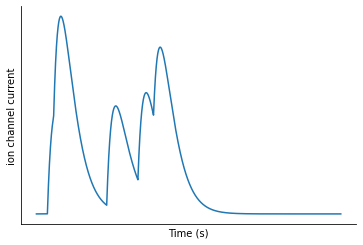

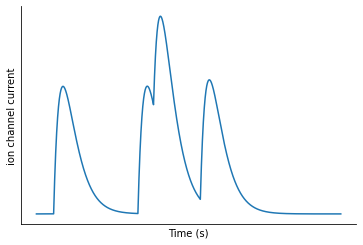

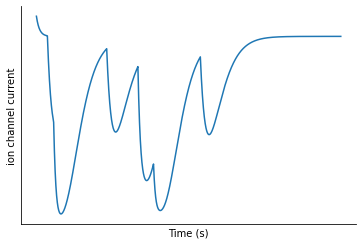

In [15]:
for i,channels in enumerate(Syn_record):
    f, ax = plt.subplots()
    ax.plot(np.arange(len(channels))[10000:]*0.025*1e-3,np.array(channels)[10000:]/max(np.array(channels)))
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('ion channel current')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.xlabel('Time (s)')
    plt.savefig('adaptive/' + str(i) + 'conc_example_i.svg')
plt.show()

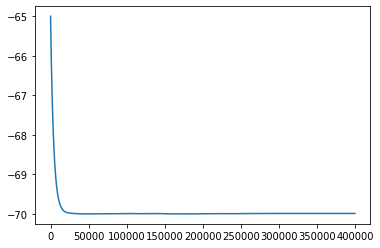

In [14]:
plt.plot(vSave)
plt.show()